In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../scripts") 
from clean_missing import fill_missing
from normalize_missing import normalize_missing
from encode_features import one_hot_encode, label_encode
from feature_utils import find_dominant_columns

In [2]:
df = pd.read_csv("train.csv")

# testowy
df_test = pd.read_csv("test.csv")
test_ids = df_test["Id"].copy()


In [3]:
# train
df_clean = fill_missing(df.copy(), "PoolQC", strategy="constant", fill_value="NoPool")
print("=== AFTER CLEANING (train) ===")
print(df_clean["PoolQC"].value_counts(dropna=False))
df = df_clean.copy()

# test
df_test_clean = fill_missing(df_test.copy(), "PoolQC", strategy="constant", fill_value="NoPool")
print("=== AFTER CLEANING (test) ===")
print(df_test_clean["PoolQC"].value_counts(dropna=False))
df_test = df_test_clean.copy()


=== AFTER CLEANING (train) ===
PoolQC
NoPool    1453
Gd           3
Ex           2
Fa           2
Name: count, dtype: int64
=== AFTER CLEANING (test) ===
PoolQC
NoPool    1456
Ex           2
Gd           1
Name: count, dtype: int64


In [4]:
print(df.info())      
print(df.shape)      


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
print(df.isna().sum().sort_values(ascending=False).head(20))

MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
TotRmsAbvGrd       0
KitchenQual        0
dtype: int64


In [6]:
print(df['PoolQC'].unique())

['NoPool' 'Ex' 'Fa' 'Gd']


In [7]:
# Cleaning categorical columns where NaN = "no feature"
replacements = {
    "MiscFeature": "None",
    "Alley": "NoAlley",
    "Fence": "NoFence",
    "MasVnrType": "None",
    "FireplaceQu": "NoFireplace",
    "GarageType": "NoGarage",
    "GarageFinish": "NoGarage",
    "GarageQual": "NoGarage",
    "GarageCond": "NoGarage",
    "BsmtFinType1": "NoBasement",
    "BsmtFinType2": "NoBasement",
    "BsmtExposure": "NoBasement",
    "BsmtQual": "NoBasement",
    "BsmtCond": "NoBasement"
}

for col, fill_val in replacements.items():
    # train
    df = fill_missing(df, col, strategy="constant", fill_value=fill_val)
    print(f"=== AFTER CLEANING {col} (train) ===")
    print(df[col].value_counts(dropna=False), "\n")

    # test
    df_test = fill_missing(df_test, col, strategy="constant", fill_value=fill_val)
    print(f"=== AFTER CLEANING {col} (test) ===")
    print(df_test[col].value_counts(dropna=False), "\n")


=== AFTER CLEANING MiscFeature (train) ===
MiscFeature
None    1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: count, dtype: int64 

=== AFTER CLEANING MiscFeature (test) ===
MiscFeature
None    1408
Shed      46
Gar2       3
Othr       2
Name: count, dtype: int64 

=== AFTER CLEANING Alley (train) ===
Alley
NoAlley    1369
Grvl         50
Pave         41
Name: count, dtype: int64 

=== AFTER CLEANING Alley (test) ===
Alley
NoAlley    1352
Grvl         70
Pave         37
Name: count, dtype: int64 

=== AFTER CLEANING Fence (train) ===
Fence
NoFence    1179
MnPrv       157
GdPrv        59
GdWo         54
MnWw         11
Name: count, dtype: int64 

=== AFTER CLEANING Fence (test) ===
Fence
NoFence    1169
MnPrv       172
GdPrv        59
GdWo         58
MnWw          1
Name: count, dtype: int64 

=== AFTER CLEANING MasVnrType (train) ===
MasVnrType
None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64 

=== AFTER CLEANING MasVnrType (test) ==

In [8]:
print(df.isna().sum().sort_values(ascending=False).head(10))

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
Electrical        1
KitchenAbvGr      0
GarageType        0
FireplaceQu       0
Fireplaces        0
Functional        0
TotRmsAbvGrd      0
dtype: int64


In [9]:
print(df['GarageYrBlt'].unique())

[2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.   nan 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927.
 1947. 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908.
 1929. 1933.]


In [10]:
# train
df = fill_missing(df, "GarageYrBlt", strategy="constant", fill_value=0)
print("TRAIN: GarageYrBlt NaN left:", df["GarageYrBlt"].isna().sum())
print("TRAIN unique:", df["GarageYrBlt"].unique())

# test
df_test = fill_missing(df_test, "GarageYrBlt", strategy="constant", fill_value=0)
print("TEST: GarageYrBlt NaN left:", df_test["GarageYrBlt"].isna().sum())
print("TEST unique:", df_test["GarageYrBlt"].unique())


TRAIN: GarageYrBlt NaN left: 0
TRAIN unique: [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.    0. 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927.
 1947. 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908.
 1929. 1933.]
TEST: GarageYrBlt NaN left: 0
TEST unique: [1961. 1958. 1997. 1998. 1992. 1993. 1990. 1970. 1999. 1971. 1975. 2009.
 2005. 2003. 2002. 2006. 2004. 1920. 1974. 2000. 2010. 1967. 1978. 1966.
 1964.    0. 1994. 1949. 1959. 1956. 1952. 1955. 1989. 1950. 1960. 1963.
 1900. 1957. 1938. 1948. 1962. 1928. 1930. 1926. 1939. 1973. 1942. 1979.
 1923. 1915. 1917. 194

In [11]:
# compute medians from train
lotfrontage_medians = df.groupby("Neighborhood")["LotFrontage"].median()

# train
df["LotFrontage"] = df["LotFrontage"].fillna(df["Neighborhood"].map(lotfrontage_medians))
print("=== AFTER CLEANING LotFrontage (train) ===")
print(df["LotFrontage"].isna().sum(), "NaN left\n")

# test
df_test["LotFrontage"] = df_test["LotFrontage"].fillna(df_test["Neighborhood"].map(lotfrontage_medians))
print("=== AFTER CLEANING LotFrontage (test) ===")
print(df_test["LotFrontage"].isna().sum(), "NaN left\n")


=== AFTER CLEANING LotFrontage (train) ===
0 NaN left

=== AFTER CLEANING LotFrontage (test) ===
0 NaN left



In [12]:
print(df["LotFrontage"].unique())

[ 65.   80.   68.   60.   84.   85.   75.   51.   50.   70.   71.   91.
  73.   72.   66.  101.   57.   44.  110.   98.   47.  108.  112.   74.
 115.   66.5  61.   48.   33.   52.  100.   24.   89.   63.   76.   81.
  95.   69.   21.   32.   78.  121.  122.   40.  105.   77.   64.   94.
  34.   90.   55.   88.   82.  120.  107.   92.  134.   62.   86.  141.
  97.   73.5  54.   41.   79.  174.   99.   67.   83.   43.  103.   93.
  30.   65.5 129.  140.   35.   37.  118.   87.  116.  150.  111.   49.
  96.   59.   36.   56.  102.   58.   38.  109.  130.   53.  137.   61.5
  45.  106.  104.   42.   39.  144.  114.  128.  149.  313.  168.  182.
 138.  160.  152.   88.5 124.  153.   46. ]


In [13]:
# MasVnrArea (constant=0)
df = fill_missing(df, "MasVnrArea", strategy="constant", fill_value=0)
print("=== AFTER CLEANING MasVnrArea (train) ===")
print(df["MasVnrArea"].isna().sum(), "NaN left\n")

df_test = fill_missing(df_test, "MasVnrArea", strategy="constant", fill_value=0)
print("=== AFTER CLEANING MasVnrArea (test) ===")
print(df_test["MasVnrArea"].isna().sum(), "NaN left\n")


# Electrical (mode from train)
mode_electrical = df["Electrical"].mode()[0]

df = fill_missing(df, "Electrical", strategy="constant", fill_value=mode_electrical)
print("=== AFTER CLEANING Electrical (train) ===")
print(df["Electrical"].isna().sum(), "NaN left\n")

df_test = fill_missing(df_test, "Electrical", strategy="constant", fill_value=mode_electrical)
print("=== AFTER CLEANING Electrical (test) ===")
print(df_test["Electrical"].isna().sum(), "NaN left\n")


=== AFTER CLEANING MasVnrArea (train) ===
0 NaN left

=== AFTER CLEANING MasVnrArea (test) ===
0 NaN left

=== AFTER CLEANING Electrical (train) ===
0 NaN left

=== AFTER CLEANING Electrical (test) ===
0 NaN left



In [14]:
print(df.dtypes.to_string())


Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [15]:
# convert MSSubClass to string (train + test)
df["MSSubClass"] = df["MSSubClass"].astype(str)
df_test["MSSubClass"] = df_test["MSSubClass"].astype(str)

# one-hot encoding
df = one_hot_encode(df, ["MSSubClass"])
df_test = one_hot_encode(df_test, ["MSSubClass"])

# align columns so train and test match
df, df_test = df.align(df_test, join="left", axis=1, fill_value=0)

print("=== TRAIN MSSubClass ===")
print(df.filter(like="MSSubClass").head())

print("\n=== TEST MSSubClass ===")
print(df_test.filter(like="MSSubClass").head())


=== TRAIN MSSubClass ===
   MSSubClass_120  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0           False           False           False           False   
1           False           False           False           False   
2           False           False           False           False   
3           False           False           False           False   
4           False           False           False           False   

   MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  \
0          False          False          False          False          False   
1           True          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  \

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 95 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              1460 non-null   int64  
 1   MSZoning        1460 non-null   object 
 2   LotFrontage     1460 non-null   float64
 3   LotArea         1460 non-null   int64  
 4   Street          1460 non-null   object 
 5   Alley           1460 non-null   object 
 6   LotShape        1460 non-null   object 
 7   LandContour     1460 non-null   object 
 8   Utilities       1460 non-null   object 
 9   LotConfig       1460 non-null   object 
 10  LandSlope       1460 non-null   object 
 11  Neighborhood    1460 non-null   object 
 12  Condition1      1460 non-null   object 
 13  Condition2      1460 non-null   object 
 14  BldgType        1460 non-null   object 
 15  HouseStyle      1460 non-null   object 
 16  OverallQual     1460 non-null   int64  
 17  OverallCond     1460 non-null   i

In [17]:
# Find potential drop columns
bad_cols = find_dominant_columns(df, threshold=0.95)

print("=== POTENTIAL DROPS ===")
print(bad_cols, "\n")

# Print distributions for flagged columns
for col in bad_cols:
    print(f"\n--- Column: {col} ---")
    print(df[col].value_counts(normalize=True, dropna=False))
    print(f"Suggestion: DROP '{col}' (dominated by '{df[col].value_counts().idxmax()}')")

=== POTENTIAL DROPS ===
['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'PoolQC', 'MiscFeature'] 


--- Column: Street ---
Street
Pave    0.99589
Grvl    0.00411
Name: proportion, dtype: float64
Suggestion: DROP 'Street' (dominated by 'Pave')

--- Column: Utilities ---
Utilities
AllPub    0.999315
NoSeWa    0.000685
Name: proportion, dtype: float64
Suggestion: DROP 'Utilities' (dominated by 'AllPub')

--- Column: Condition2 ---
Condition2
Norm      0.989726
Feedr     0.004110
Artery    0.001370
RRNn      0.001370
PosN      0.001370
PosA      0.000685
RRAn      0.000685
RRAe      0.000685
Name: proportion, dtype: float64
Suggestion: DROP 'Condition2' (dominated by 'Norm')

--- Column: RoofMatl ---
RoofMatl
CompShg    0.982192
Tar&Grv    0.007534
WdShngl    0.004110
WdShake    0.003425
Metal      0.000685
Membran    0.000685
Roll       0.000685
ClyTile    0.000685
Name: proportion, dtype: float64
Suggestion: DROP 'RoofMatl' (dominated by 'CompShg')

--- Column: Heating ---
H

In [18]:
cols_to_drop = ["Utilities", "Street", "Condition2", "RoofMatl", 
                "Heating", "MiscFeature", "MoSold", "Id"]

# train
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
print("Dropped columns (train):", cols_to_drop)
print("Remaining shape (train):", df.shape)

# test
df_test = df_test.drop(columns=[c for c in cols_to_drop if c in df_test.columns])
print("Dropped columns (test):", cols_to_drop)
print("Remaining shape (test):", df_test.shape)


Dropped columns (train): ['Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature', 'MoSold', 'Id']
Remaining shape (train): (1460, 87)
Dropped columns (test): ['Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature', 'MoSold', 'Id']
Remaining shape (test): (1459, 87)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 87 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSZoning        1460 non-null   object 
 1   LotFrontage     1460 non-null   float64
 2   LotArea         1460 non-null   int64  
 3   Alley           1460 non-null   object 
 4   LotShape        1460 non-null   object 
 5   LandContour     1460 non-null   object 
 6   LotConfig       1460 non-null   object 
 7   LandSlope       1460 non-null   object 
 8   Neighborhood    1460 non-null   object 
 9   Condition1      1460 non-null   object 
 10  BldgType        1460 non-null   object 
 11  HouseStyle      1460 non-null   object 
 12  OverallQual     1460 non-null   int64  
 13  OverallCond     1460 non-null   int64  
 14  YearBuilt       1460 non-null   int64  
 15  YearRemodAdd    1460 non-null   int64  
 16  RoofStyle       1460 non-null   object 
 17  Exterior1st     1460 non-null   o

In [20]:
def print_feature_groups(df, name="DF"):
    # continuous numeric
    num_cont = [
        col for col in df.select_dtypes(include=["int64", "float64"]).columns
        if col not in [
            "OverallQual", "OverallCond", "SalePrice", 
            "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath",
            "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", 
            "Fireplaces", "GarageCars",
            "YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold", "MoSold"
        ] if col in df.columns  # safeguard
    ]

    ord_cols = [c for c in ["OverallQual", "OverallCond"] if c in df.columns]

    count_cols = [c for c in [
        "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath",
        "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd",
        "Fireplaces", "GarageCars"
    ] if c in df.columns]

    time_cols = [c for c in [
        "YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold", "MoSold"
    ] if c in df.columns]

    cat_cols = list(df.select_dtypes(include=["object", "bool"]).columns)

    print(f"\n=== {name} ===")
    print("\nContinuous numeric:\n", num_cont)
    print("\nOrdinal numeric:\n", ord_cols)
    print("\nCount-like numeric:\n", count_cols)
    print("\nTime-like numeric:\n", time_cols)
    print("\nCategorical:\n", cat_cols)


# check both
print_feature_groups(df, "TRAIN")
print_feature_groups(df_test, "TEST")



=== TRAIN ===

Continuous numeric:
 ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

Ordinal numeric:
 ['OverallQual', 'OverallCond']

Count-like numeric:
 ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

Time-like numeric:
 ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

Categorical:
 ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'Garage

In [21]:
df.shape

(1460, 87)

In [22]:
# correlation with target (numeric only)
corr_with_target = (
    df.select_dtypes(include=["int64", "float64"])
      .corr(numeric_only=True)["SalePrice"]
      .sort_values(ascending=False)
)

print("\nCorrelation with SalePrice:\n", corr_with_target)



Correlation with SalePrice:
 SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.349876
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [23]:
cat_means = df.groupby("Neighborhood")["SalePrice"].mean().sort_values()
print(cat_means.head())
print(cat_means.tail())


Neighborhood
MeadowV     98576.470588
IDOTRR     100123.783784
BrDale     104493.750000
BrkSide    124834.051724
Edwards    128219.700000
Name: SalePrice, dtype: float64
Neighborhood
Veenker    238772.727273
Timber     242247.447368
StoneBr    310499.000000
NridgHt    316270.623377
NoRidge    335295.317073
Name: SalePrice, dtype: float64


<Axes: xlabel='YrSold'>

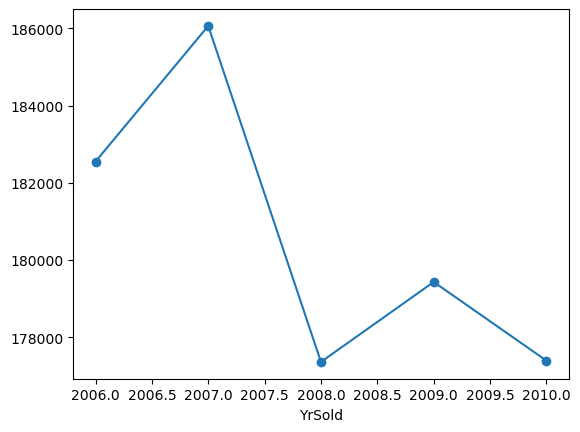

In [24]:
df.groupby("YrSold")["SalePrice"].mean().plot(kind="line", marker="o")


In [25]:
def feature_engineering(df):
    df = df.copy()
    
    # ages
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["GarageAge"] = df["YrSold"] - df["GarageYrBlt"]
    
    # totals
    df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"]
    df["TotalBaths"] = (
        df["FullBath"] + df["HalfBath"] * 0.5 +
        df["BsmtFullBath"] + df["BsmtHalfBath"] * 0.5
    )
    
    # binary flags
    df["HasPool"] = (df["PoolArea"] > 0).astype(int)
    df["Has3SsnPorch"] = (df["3SsnPorch"] > 0).astype(int)
    df["HasMiscVal"] = (df["MiscVal"] > 0).astype(int)
    
    # ratios
    df["RoomsPerBedroom"] = df["TotRmsAbvGrd"] / (df["BedroomAbvGr"] + 1)  # avoid div/0
    df["LivAreaPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] + 1)
    
    return df


In [26]:
df = feature_engineering(df)
df_test = feature_engineering(df_test)


In [27]:
df.shape

(1460, 97)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 97 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSZoning         1460 non-null   object 
 1   LotFrontage      1460 non-null   float64
 2   LotArea          1460 non-null   int64  
 3   Alley            1460 non-null   object 
 4   LotShape         1460 non-null   object 
 5   LandContour      1460 non-null   object 
 6   LotConfig        1460 non-null   object 
 7   LandSlope        1460 non-null   object 
 8   Neighborhood     1460 non-null   object 
 9   Condition1       1460 non-null   object 
 10  BldgType         1460 non-null   object 
 11  HouseStyle       1460 non-null   object 
 12  OverallQual      1460 non-null   int64  
 13  OverallCond      1460 non-null   int64  
 14  YearBuilt        1460 non-null   int64  
 15  YearRemodAdd     1460 non-null   int64  
 16  RoofStyle        1460 non-null   object 
 17  Exterior1st   

In [29]:
ordinal_cols = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
    "KitchenQual", "HeatingQC", "FireplaceQu",
    "GarageQual", "GarageCond", "PoolQC"
]

for col in ordinal_cols:
    print(f"{col}: {df[col].unique()}")


ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
ExterCond: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual: ['Gd' 'TA' 'Ex' 'NoBasement' 'Fa']
BsmtCond: ['TA' 'Gd' 'NoBasement' 'Fa' 'Po']
KitchenQual: ['Gd' 'TA' 'Ex' 'Fa']
HeatingQC: ['Ex' 'Gd' 'TA' 'Fa' 'Po']
FireplaceQu: ['NoFireplace' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageQual: ['TA' 'Fa' 'Gd' 'NoGarage' 'Ex' 'Po']
GarageCond: ['TA' 'Fa' 'NoGarage' 'Gd' 'Po' 'Ex']
PoolQC: ['NoPool' 'Ex' 'Fa' 'Gd']


In [30]:
def encode_ordinal(df):
    df = df.copy()
    
    # ExterQual / ExterCond / KitchenQual / HeatingQC
    qual_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}
    
    # BsmtQual / BsmtCond (with NoBasement)
    bsmt_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoBasement": 0}
    
    # FireplaceQu (with NoFireplace)
    fireplace_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoFireplace": 0}
    
    # GarageQual / GarageCond (with NoGarage)
    garage_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NoGarage": 0}
    
    # PoolQC (with NoPool)
    pool_map = {"Ex": 5, "Gd": 4, "Fa": 2, "NoPool": 0}
    
    # apply mappings
    df["ExterQual"]   = df["ExterQual"].map(qual_map)
    df["ExterCond"]   = df["ExterCond"].map(qual_map)
    df["BsmtQual"]    = df["BsmtQual"].map(bsmt_map)
    df["BsmtCond"]    = df["BsmtCond"].map(bsmt_map)
    df["KitchenQual"] = df["KitchenQual"].map(qual_map)
    df["HeatingQC"]   = df["HeatingQC"].map(qual_map)
    df["FireplaceQu"] = df["FireplaceQu"].map(fireplace_map)
    df["GarageQual"]  = df["GarageQual"].map(garage_map)
    df["GarageCond"]  = df["GarageCond"].map(garage_map)
    df["PoolQC"]      = df["PoolQC"].map(pool_map)
    
    return df


In [31]:
df = encode_ordinal(df)
df_test = encode_ordinal(df_test)


In [32]:
df[["ExterQual","BsmtQual","FireplaceQu"]].head()

,ExterQual,BsmtQual,FireplaceQu
0,4,4,0
1,3,4,3
2,4,4,3
3,3,3,4
4,4,4,3


In [33]:
cat_cols = df.select_dtypes(include=["object", "bool"]).columns

for col in cat_cols:
    print(f"{col}: {df[col].unique()}\n")


MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']

Alley: ['NoAlley' 'Grvl' 'Pave']

LotShape: ['Reg' 'IR1' 'IR2' 'IR3']

LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']

LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']

LandSlope: ['Gtl' 'Mod' 'Sev']

Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']

Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']

BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']

HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']

RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']

Exterior1st: ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']

Exterior2nd: ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard

In [34]:
def combine_exterior(df):
    df = df.copy()
    df["Exterior"] = df["Exterior1st"] + "_" + df["Exterior2nd"]
    df.drop(["Exterior1st", "Exterior2nd"], axis=1, inplace=True)
    return df
df = combine_exterior(df)
df_test = combine_exterior(df_test)


In [35]:
def simplify_functional(df):
    df = df.copy()
    df["IsFunctional"] = (df["Functional"] == "Typ").astype(int)
    df.drop("Functional", axis=1, inplace=True)
    return df
df = simplify_functional(df)
df_test = simplify_functional(df_test)


In [36]:
print(df["Electrical"].value_counts(normalize=True))

Electrical
SBrkr    0.914384
FuseA    0.064384
FuseF    0.018493
FuseP    0.002055
Mix      0.000685
Name: proportion, dtype: float64


In [37]:
def simplify_electrical(df):
    df = df.copy()
    if "Electrical" in df.columns:
        df["Electrical"] = df["Electrical"].replace(["FuseF", "FuseP", "Mix"], "Other")
    return df
df = simplify_electrical(df)
df_test = simplify_electrical(df_test)


In [38]:
# One-Hot Encoding for remaining object columns
df = pd.get_dummies(df, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)

# align columns (make sure train and test match)
df, df_test = df.align(df_test, join="left", axis=1, fill_value=0)

print("Final shape after One-Hot (train):", df.shape)
print("Final shape after One-Hot (test):", df_test.shape)


Final shape after One-Hot (train): (1460, 258)
Final shape after One-Hot (test): (1459, 258)


In [39]:
import pandas as pd

def correlation_with_target(df, target="SalePrice", top_n=30):
    """
    Calculates correlation of all numeric columns with the target.
    Returns sorted Series and prints top_n features.
    """
    # numeric only
    corr = df.corr(numeric_only=True)[target].sort_values(ascending=False)
    
    # drop self-correlation (target = target)
    corr = corr.drop(target)
    
    # show top features
    print(f"Top {top_n} positive correlations with {target}:\n")
    print(corr.head(top_n))
    
    print(f"\nTop {top_n} negative correlations with {target}:\n")
    print(corr.tail(top_n))
    
    return corr


In [40]:
corr = correlation_with_target(df, target="SalePrice", top_n=15)


Top 15 positive correlations with SalePrice:

OverallQual       0.790982
TotalSF           0.782260
GrLivArea         0.708624
ExterQual         0.682639
KitchenQual       0.659600
GarageCars        0.640409
TotalBaths        0.631731
GarageArea        0.623431
LivAreaPerRoom    0.616235
TotalBsmtSF       0.613581
1stFlrSF          0.605852
BsmtQual          0.585207
FullBath          0.560664
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
Name: SalePrice, dtype: float64

Top 15 negative correlations with SalePrice:

RoofStyle_Gable         -0.224744
GarageType_NoGarage     -0.236832
GarageFinish_NoGarage   -0.236832
MSSubClass_30           -0.238640
SaleType_WD             -0.242598
GarageAge               -0.261441
BsmtExposure_No         -0.263600
LotShape_Reg            -0.267672
MSZoning_RM             -0.288065
Foundation_CBlock       -0.343263
GarageType_Detchd       -0.354141
MasVnrType_None         -0.367456
GarageFinish_Unf        -0.410608
RemodAge                -0.5

In [41]:
# rozdzielamy target i cechy
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

print(X.shape, y.shape)


(1460, 257) (1460,)


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np

# train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [58]:
best_xgb = XGBRegressor(
    n_estimators=800,       # zamiast 500
    learning_rate=0.05,     # zamiast 0.1
    max_depth=3,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=-1
)


best_xgb.fit(X, y)


final_preds = best_xgb.predict(X_test)

# submission
submission = pd.DataFrame({
    "Id": test_ids,
    "SalePrice": final_preds
})

submission.to_csv("submission_hyper.csv", index=False)
print("✅ submission_hyper.csv gotowe do uploadu")


✅ submission_hyper.csv gotowe do uploadu
